## (a) Define the MDP

- $\mathcal{T}$ decision epochs (measured in days)
- $\mathcal{S}$ states where $s$ represents states; a tuple of number of cars at each location
- $\mathcal{A}$ actions where each action $a$ can be represented as a tuple that sums to $0$ and 
each element represents the number of cars moved in relation to the indexed location. For example $a = \{-1,0,1\}$
would represent the movement of a single car from location 1 (or more properly, location 0) to the third location.
It is assumed that one cannot move more cars from a location than exist at that location. So the valid 
actions are all $a\in\mathcal{A}_s$ for which $a+s$ is non-negative.

First, we import the supporting python libraries and enumerate the constants defined by Sutton and Barto for this problem.

In [ ]:
# Testing support
from datetime import datetime
'''
start_time = datetime.now()
###############################

###############################
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))
'''

In [253]:
import numpy as np
from scipy.stats import poisson
from itertools import product as cartesian_product
import matplotlib.pyplot as plt

REQUEST_LAM = [3,4]             # Poisson expectation of requests per location
RETURN_LAM  = [3,2]             # Poisson expectation of returns per location
MAX_CARS = np.array([20,20])    # length  is implicitly the number of locations
#MAX_CARS = np.array([4,4])    # length  is implicitly the number of locations
NUM_LOCATIONS = len(MAX_CARS)   # dimension of the state-space tuple
DISCOUNT = 0.9                  # \gamma
MAX_MOVE = 5
MOVE_COST = 2
RENT_CREDIT = [10,10]                # Can also be defined as an array
THETA = 1e-4

- State transition function $S^M (S_t, A_t)$
    - Will assume the parameters defined above, and provide a stochastic mapping from $S_t,A_t$ to $S_t+1$
    - For computational efficiency this function can also use an intermediate variable to calculate reward
    - Is easier to write out than transition probability

- Transition Probability Function
is a convolution of $\sim\text{poisson}(\lambda_i) \forall\lambda_i\in\Lambda$ 
where $\Lambda$ is the set of expected values in the Poisson processes that represent customer behavior
for both rental requests and returns. Each location's individual transition probability is $\sim\text{skellam}(\lambda_1,\lambda_2)$ parameterized on the expected returns and expected requests

In the case of $p(s^\prime|s)$:

In [222]:
def transition_probabilities(max_cars,req_lam,ret_lam):
    """Returns a 2D array of probabilities P[x,y] mapping
    x = future state, y = current state
    
    e.g. 
    p(x|y) : probability of future state x given current state y
    """
    num_states = max_cars+1
    states = request_range = return_range = np.arange(num_states)
    trans_probs = np.zeros([num_states]*2)

    # probability matrices x,y where given x cars on lot, y cars are rented or returned
    rental_probs = (np.tri(num_states)*poisson.pmf(request_range, req_lam) +
                    np.eye(num_states)*(1-poisson.cdf(request_range, req_lam)) )

    return_probs = (np.tri(num_states)*poisson.pmf(return_range,ret_lam) +
                    np.eye(num_states)*(1-poisson.cdf(return_range,ret_lam)) )

    # Convolve
    for current_state in states:
        for future_state in states:
            for cars_rented in range(current_state+1):

                open_spaces = max_cars - current_state + cars_rented
                cars_returned = future_state - current_state + cars_rented
                if cars_returned < 0: continue

                trans_probs[future_state,current_state] += (
                    rental_probs[current_state,cars_rented] * 
                    return_probs[open_spaces,cars_returned] )

    return trans_probs


def transition_probabilities_by_loc(location):
    args = MAX_CARS[location], REQUEST_LAM[location], RETURN_LAM[location]
    return transition_probabilities(*args)


- $r(s,a,s^\prime)$ Reward function
is the product of the cars successfully rented minus the cost of transfers made during action $a$
$$\text{credit}(s^\prime - s - a) - \text{cost}(a)$$

Next, we define an expected return function that will represent both the
$$
V(s)\leftarrow \sum_{s^\prime,r} p(s^\prime,r|s,\pi(s)) \left[r+\gamma V(s^\prime)\right]
$$
in the case of policy iteration, and
$$
V(s)\leftarrow \max_a \sum_{s^\prime,r} p(s^\prime,r|s,a) \left[r+\gamma V(s^\prime)\right]
$$
in the case of value iteration.

In [259]:
def expected_rentals(max_cars,req_lam):
    """Returns array of expected rentals indexed by the current state"""
    states = np.arange(max_cars+1)
    req_probs = poisson.pmf(states, req_lam)
    Ex = np.zeros(states.shape)

    for current_state in states:
        # p[i]: probability of renting out i cars
        rental_probs = np.append(req_probs[:current_state],
                           1-poisson.cdf(current_state-1, req_lam))
        Ex[current_state] = np.sum(states[:current_state + 1] * rental_probs)

    return Ex


def expected_rentals_by_loc(location):
    args = MAX_CARS[location],REQUEST_LAM[location]
    return expected_rentals(*args)


def expected_returns_by_state():
    expected_returns_by_loc = [fee * expected_rentals_by_loc(location) 
                               for location,fee in enumerate(RENT_CREDIT)]

    expected_returns_by_state = np.array(
        [sum(comb) for comb in cartesian_product(*expected_returns_by_loc)]
        ).reshape([len(_) for _ in expected_returns_by_loc])

    return expected_returns_by_state

def calc_discounted_expected_returns(value_function, discount=DISCOUNT):
    P1 = transition_probabilities_by_loc(location=0)
    P2 = transition_probabilities_by_loc(location=1)
    v = expected_returns_by_state() + DISCOUNT * P1.T.dot(value_function).dot(P2)
    return v

Unrelated to the MDP itself, we also define a plotting function that will provide a graphic somewhat similar to Sutton and Barto's

In [244]:
def plot_policy(policy,location=0):
    try:
        plt.imshow(policy[:,:,location], cmap='viridis', origin='lower')
    except:
        plt.imshow(policy, cmap='viridis', origin='lower')
    plt.colorbar(label='Number of cars moved from location 1 to 2')
    plt.xlabel('Number of cars at location 2')
    plt.ylabel('Number of cars at location 1')
    plt.title('Policy Grid')
    plt.show()

## (b) Dynamic Programming

Policy Grid after iteration 126: 


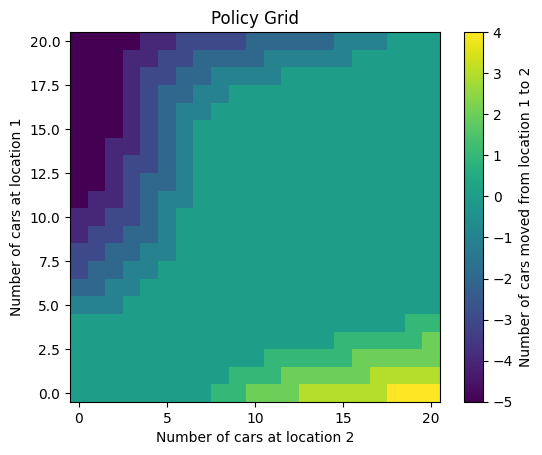

In [263]:
def policy_iteration(max_iterations = 10**100,policy=None, value_function=None, 
                     verbose=False, extended_problem_flag=False):

    # 1. Initialization
    value_function = value_function or np.zeros(np.add(MAX_CARS,1))
    policy = policy or np.zeros([*np.add(MAX_CARS,1),len(MAX_CARS)], dtype=int)

    # 2. Policy Evaluation
    policy_stable = False
    iteration = 0

    while not policy_stable and iteration < max_iterations:
        delta = 0
        edfr = calc_discounted_expected_returns(value_function)

        # a proxy for s \in S
        for state,old_value in np.ndenumerate(value_function):

            action = policy[state]
            s_prime = np.add(state,action)
            if np.greater(s_prime,MAX_CARS).any() or np.less(s_prime,0).any(): continue # Skip in invalid action
            transfer_cost = MOVE_COST * np.sum(np.abs(action))/2

            value_function[*state] = edfr[*s_prime] - transfer_cost

            delta = max(delta, abs(old_value - value_function[state]))

        if delta < THETA:
                break


        # 3. Policy Improvement
        policy_stable = True

        edfr = calc_discounted_expected_returns(value_function)
        # a proxy for s \in S
        for state,old_value in np.ndenumerate(value_function):
            v_max = old_value
            a_max = policy[state]

            # ARGMAX fro action range
            for a in range(-MAX_MOVE, MAX_MOVE + 1):
                action = [-a,a]
                s_prime = np.add(state,action)
                                
                if np.greater(s_prime,MAX_CARS).any() or np.less(s_prime,0).any(): continue # Skip in invalid action
                transfer_cost = MOVE_COST * np.sum(np.abs(action))/2
                v_candidate = edfr[*s_prime] - transfer_cost
                
                if v_candidate > v_max:
                    policy_stable = False
                    v_max = v_candidate
                    a_max = action
            
            policy[state] = a_max

        if verbose:
            print("Policy Grid after iteration {}: ".format(iteration + 1))
            plot_policy(policy)
        iteration += 1

    print("Policy Grid after iteration {}: ".format(iteration + 1))
    plot_policy(policy)
    return policy, value_function


_,_ = policy_iteration()

## (c) Policy Insights

Although inefficiencies in the code above and limitations in the hardware employed to run the scripts prevented a full sized running of the solution, the general nature of the change in the policy can be distinctly seen. In particular, Jack is far more likely make the move that occurs free of charge. This resulted in the 'banding' being a bit wider than under the original problem conditions.

The extreme corner values increased to a higher number than in the base problem; but at this scale neither corner meets the maximum move limit. This could mean that the unconstrained optimal at those corners is higher, with the observable result being an increase in the areas of maximum movement (specifically the 5 and -4 on page 81).

Initially, the new lot fee was left to initiate at 10 cars. The effect of this change cannot be seen the smaller maximums. In order to attempt to recapture the probable effect of this factor we redefined this to be half of the location's max capacity.

Once the lot fee incurrence was reduced to actually effect the problem at this level the
difference can be seen in the behavior on the upper right hand quadrant. In the original problem there is no consequence to being in this region, in fact having the inventory to service greater demand will be a potential benefit.
Once the cost is added, there is a greater incentive to move vehicles to the other location to reduce the probability of having to rent an overflow lot. The new motive force can be visualized as:

<img src="Blank diagram.png" width="200">

## (d) Dynamic Programming

Value function update iteration 1, delta: 97.83327439972055
Value function update iteration 2, delta: 45.78239576760937
Value function update iteration 3, delta: 27.30041544076471
Value function update iteration 4, delta: 17.73890183656517
Value function update iteration 5, delta: 10.852840615654031
Value function update iteration 6, delta: 6.436770664102511
Value function update iteration 7, delta: 3.7785100323632435
Value function update iteration 8, delta: 2.2115610973956876
Value function update iteration 9, delta: 1.2933537500517787
Value function update iteration 10, delta: 0.7561818595401775
Value function update iteration 11, delta: 0.4421060002959081
Value function update iteration 12, delta: 0.2584723956609736
Value function update iteration 13, delta: 0.15111128824392495
Value function update iteration 14, delta: 0.0883442973178461
Value function update iteration 15, delta: 0.051648756575602306
Value function update iteration 16, delta: 0.030195424667979864
Value function up

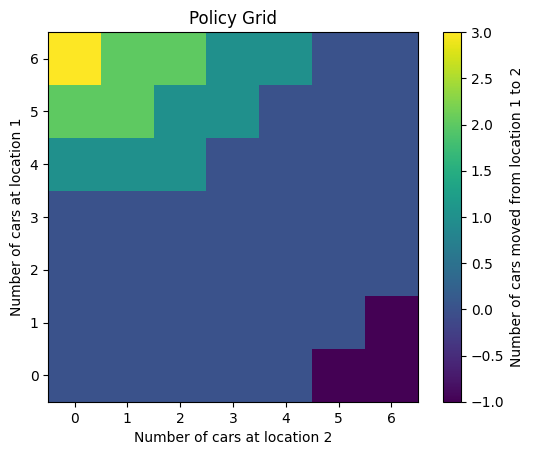

Optimal Policy:
[[ 0  0  0  0  0 -1 -1]
 [ 0  0  0  0  0  0 -1]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 1  1  1  0  0  0  0]
 [ 2  2  1  1  0  0  0]
 [ 3  2  2  1  1  0  0]]
Value Function:
[[102.11426861 110.31823759 118.24676128 125.58114709 132.02101706
  138.0686674  143.41568985]
 [110.16980703 118.37358003 126.30113642 133.63307192 140.06867366
  145.41569623 150.73060627]
 [117.54191903 125.74485773 133.66831364 140.98990646 147.40759767
  152.73061497 156.879045  ]
 [123.78118433 131.98225826 139.8965644  147.19513965 153.57315173
  158.84337308 162.93404839]
 [129.98226676 137.89657143 145.19514636 152.0470583  158.36345931
  163.55212225 167.55428846]
 [135.89657861 143.1951524  150.04706377 156.36346493 161.8292083
  166.91951133 170.81546268]
 [141.19515744 148.04706914 154.36347063 159.82921726 164.91952067
  169.14213315 172.93353878]]


In [10]:
def value_iteration(policy = None, value_function = None):
    # 1. Initialization
    value_function = value_function or np.zeros(np.add(MAX_CARS,1))
    policy = policy or np.zeros((MAX_CARS[0] + 1, MAX_CARS[1] + 1), dtype=int) 
    
    iteration = 0
    while True:
        delta = 0
        for index, old_value in np.ndenumerate(value_function):
            action_returns = []
            for action in range(-MAX_MOVE, MAX_MOVE + 1):
                if (0 <= index[0] - action <= MAX_CARS[0] 
                and 0 <= index[1] + action <= MAX_CARS[1]):
                    action_returns.append(
                        expected_return((index), action, value_function))
                else:
                    action_returns.append(-float('inf'))
            
            value_function[index] = max(action_returns)
            delta = max(delta, abs(old_value - value_function[index]))
        
        print(f"Value function update iteration {iteration+1}, delta: {delta}")
        if delta < THETA:
            break
        
        iteration += 1

    # Policy extraction from the value function
    for index, old_value in np.ndenumerate(value_function):
        action_returns = []
        for action in range(-MAX_MOVE, MAX_MOVE + 1):
            if (0 <= index[0] - action <= MAX_CARS[0] 
            and 0 <= index[1] + action <= MAX_CARS[1]):
                action_returns.append(
                    expected_return((index), action, value_function))
            else:
                action_returns.append(-float('inf'))
        policy[index] = np.argmax(action_returns) - MAX_MOVE
    
    print("Policy after value iteration:")
    plot_policy(policy)
    return policy, value_function

MAX_CARS = np.array([6,6])
# Run value iteration algorithm
policy, value_function = value_iteration()
print("Optimal Policy:")
print(policy)
print("Value Function:")
print(value_function)
#3:2.6 @5x5
#14:26.5 @6x6

Value function update iteration 1, delta: 26407.693345747586
Value function update iteration 2, delta: 13252.561171691981
Value function update iteration 3, delta: 8025.179910451319
Value function update iteration 4, delta: 5423.878943659642
Value function update iteration 5, delta: 3408.378681659353
Value function update iteration 6, delta: 2046.9436141182741
Value function update iteration 7, delta: 1208.8607778772348
Value function update iteration 8, delta: 708.7260548774866
Value function update iteration 9, delta: 413.92018656563596
Value function update iteration 10, delta: 241.20307169784792
Value function update iteration 11, delta: 140.3924209712277
Value function update iteration 12, delta: 81.67993263000972
Value function update iteration 13, delta: 47.51543346667313
Value function update iteration 14, delta: 27.640276460224413
Value function update iteration 15, delta: 16.07857880503434
Value function update iteration 16, delta: 9.353030366481107
Value function update iter

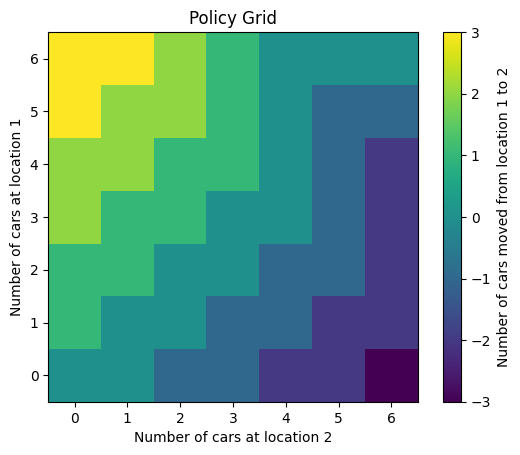

Optimal Policy:
[[ 0  0 -1 -1 -2 -2 -3]
 [ 1  0  0 -1 -1 -2 -2]
 [ 1  1  0  0 -1 -1 -2]
 [ 2  1  1  0  0 -1 -2]
 [ 2  2  1  1  0 -1 -2]
 [ 3  2  2  1  0 -1 -1]
 [ 3  3  2  1  0  0  0]]
Value Function:
[[-38917.89299437 -39118.39576682 -39338.32829574 -39787.76881278
  -40296.3627526  -41054.79346137 -41902.7650907 ]
 [-39118.39576885 -39336.32829796 -39785.76881607 -40294.36275663
  -41052.79346599 -41900.76509461 -43019.5219744 ]
 [-39336.32830354 -39785.76882117 -40292.36276181 -41050.79347206
  -41898.76510039 -43017.52198034 -44203.38973193]
 [-39787.768829   -40292.36276788 -41050.79347808 -41896.76510616
  -43015.52198643 -44201.38973731 -45440.42054634]
 [-40294.36277487 -41052.793484   -41896.7651112  -43015.52199163
  -44199.38974236 -45438.42055095 -46645.5245701 ]
 [-41054.79348924 -41898.76511575 -43017.5219959  -44199.38974661
  -45436.42055531 -46643.52457422 -47985.72168021]
 [-41900.76511955 -43019.52199937 -44201.38975092 -45436.42056208
  -46641.52458528 -47983.721691

In [11]:
def value_iteration(policy = None, value_function = None):
    # 1. Initialization
    value_function = value_function or np.zeros(np.add(MAX_CARS,1))
    policy = policy or np.zeros((MAX_CARS[0] + 1, MAX_CARS[1] + 1), dtype=int) 
    
    iteration = 0
    while True:
        delta = 0
        for index, old_value in np.ndenumerate(value_function):
            action_returns = []
            for action in range(-MAX_MOVE, MAX_MOVE + 1):
                if (0 <= index[0] - action <= MAX_CARS[0] 
                and 0 <= index[1] + action <= MAX_CARS[1]):
                    action_returns.append(
                        modified_return((index), action, value_function))
                else:
                    action_returns.append(-float('inf'))
            
            value_function[index] = max(action_returns)
            delta = max(delta, abs(old_value - value_function[index]))
        
        print(f"Value function update iteration {iteration + 1}, delta: {delta}")
        if delta < THETA:
            break
        
        iteration += 1

    # Policy extraction from the value function
    for index, old_value in np.ndenumerate(value_function):
        action_returns = []
        for action in range(-MAX_MOVE, MAX_MOVE + 1):
            if (0 <= index[0] - action <= MAX_CARS[0] 
            and 0 <= index[1] + action <= MAX_CARS[1]):
                action_returns.append(
                    modified_return((index), action, value_function))
            else:
                action_returns.append(-float('inf'))
        policy[index] = np.argmax(action_returns) - MAX_MOVE
    
    print("Policy after value iteration:")
    plot_policy(policy)
    return policy, value_function

MAX_CARS = np.array([6,6])
# Run value iteration algorithm
policy, value_function = value_iteration()
print("Optimal Policy:")
print(policy)
print("Value Function:")
print(value_function)
#3:2.6 @5x5
#14:26.5 @6x6

## (e) Algorithm Comparison

It is possible that that all observations are the result of bias in the coding of each algorithm.

Value iteration seemed to be a more straightforward implementation than policy iteration. However, when the two were implemented with the intent to keep their operation as similar as possible the policy iteration concluded in significantly shorter time. The resulting policies were quite similar, but under the extended problem the behavior in the quadrant marking overflow lot usage appears to blend more with the behavior outside the quadrant at the edges.
